## Setup

First, we set up our notebook by downloading the appropriate packages

### Dependencies

In [1]:
pip install matplotlib scipy pandas numpy networkx seaborn scikit-learn cython

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/41/f1/115e7c79b4506b4f0533acba742babd9718ff92eeca6d4205843173b6173/matplotlib-3.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/89/bb/80c9c98d887c855710fd31fc5ae5574133e98203b3475b07579251803662/scipy-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.5 MB/s eta 0:00:00
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/fc/a5/4d82be566f069d7a9a702dcdf6f9106df0e0b042e738043c0cc7ddd7e3f6/pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/d1/27/2a7bd6855dc717aeec5f553073a3c426b9c816126555f8e616392eab856b/numpy-2.0.0-cp311-cp311-manylinux_2_17_

### Imports

In [2]:
# base libraries
import importlib
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import os

import networkx as nx

import time

from IPython.utils.io import capture_output # supress outputs

from sklearn.metrics.cluster import adjusted_rand_score

### Fix pathway

In [3]:
# fix directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)

print("Current working directory:", os.getcwd())

from trcrpm.src import Hierarchical_TRCRP_Mixture, TRCRP_Mixture

Current working directory: /hdsi-collab-persistent/cephfs/Setup


### Helper Functions

1. **`run_model(data, num_chains = 8, p = 5, MCMC_steps=1000, hyperparam_steps=50, runtime = True)`**
    - **Returns**: Fitted model
        - The dataframe index needs to be reset as an integer.
        - Choose a high number for `MCMC_steps` to allow for a burn-in period.
        - `p` is our lag window

2. **`post_dep(model, num_samples)`**
    - **Returns**: Pairwise posterior dependence matrices (cluster probabilities)
        - The array is of size `NUM_SAMPLES x NUM_CHAINS x LEN(DF) x LEN(DF)`

3. **`clustering(post_probs, threshold = 0.75)`**
    - **Returns**: Clusters
        - If time series `i` and `k` are dependent in `threshold%` of samples, they are clustered together.
        - Averages over `NUM_SAMPLES` and `NUM_CHAINS`.

4. **`return_ari(true_labels, predicted_clusters)`**
    - **Returns**: Adjusted Rand Index (ARI) if ground truth is available


In [4]:
import importlib

In [5]:
import experiments.helper_functions as helpers
importlib.reload(helpers)

<module 'experiments.helper_functions' from '/hdsi-collab-persistent/cephfs/Setup/experiments/helper_functions.py'>

# Data 1(Sin Waves)

In [6]:
?data_gen.generate_sine_wave_data

Object `data_gen.generate_sine_wave_data` not found.


,0,1,2,3,4
0,0.000000,1.000000,2.000000,0.000000,1.000000
1,-0.698144,0.143767,0.211041,0.360933,0.387355
2,-0.371716,-0.387578,2.204021,0.592673,-0.540718
3,0.274139,-2.368298,4.626330,0.203212,-2.004217
4,0.151679,-2.218308,4.527189,0.421443,-2.068086


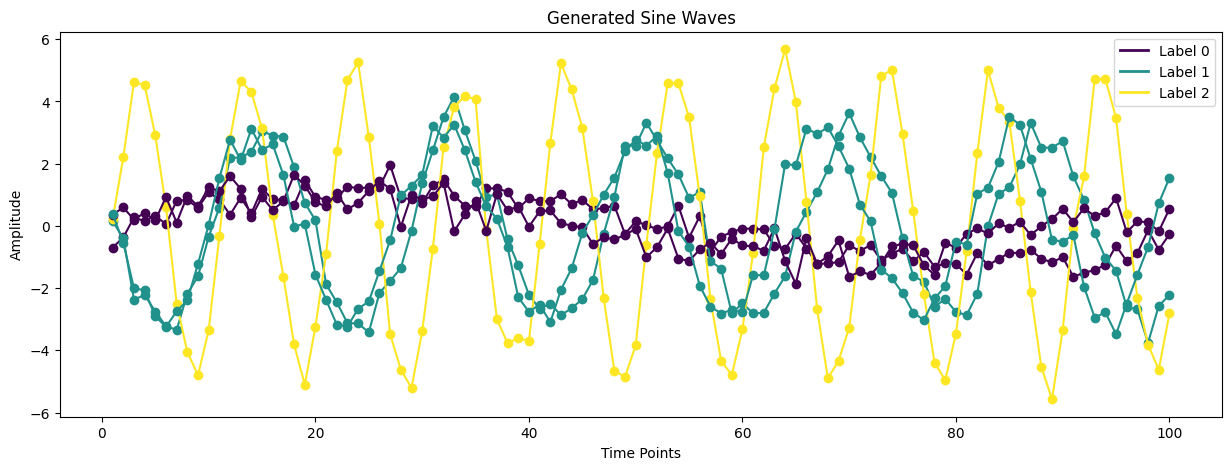

In [7]:
import experiments.data_generation as data_gen
importlib.reload(data_gen)

df = data_gen.generate_sine_wave_data(frequency_noise=0.1, random_state=42, use_colors = True, num_clusters = 3,
                                     num_samples = 5)
df.head()

## Run Analysis

In [8]:
data = df.iloc[1:]
labels = df.iloc[0].values

print(data.shape) # NUM_OBSERVATIONS X NUM_TIMESEREIES

(100, 5)


In [9]:
model = helpers.run_model(data)

MCMC inference time: 1 minutes and 3 seconds
Hyperparameter optimization time: 0 minutes and 44 seconds


In [10]:
dep_matrices = helpers.post_dep(model, 20)

Sampling Time: 0 minutes and 22 seconds


In [11]:
# compare predicted and true clusters

In [12]:
predicted_clusters = helpers.clustering(dep_matrices, threshold = 0.75)
predicted_clusters

[{0, 3}, {1, 4}, {2}]

In [13]:
helpers.return_ari(labels, predicted_clusters)

1.0

In [14]:
unique_labels = np.unique(labels)
# step size (number of elements per cluster)
step = len(labels) // len(unique_labels)

# clusters as list 
clusters = [[int(label) for label in np.where(labels == label)[0]] for label in unique_labels]
clusters

[[0, 3], [1, 4], [2]]

## Plotting


In [15]:
import plotting_functions as plot
importlib.reload(plot)

<module 'plotting_functions' from '/hdsi-collab-persistent/cephfs/Setup/experiments/plotting_functions.py'>

In [16]:
# #%%capture
# # need to simulate samples for confidence interval
# # we sample from the posterior to get confidence interval for forecasted values
# # some bug inside .simulate so supressing outputs for now
# # bug is in cgpm.src.crosscat.sampling (print statement in simulate_row)
# probes = model.dataset.index
# numsamples = 10
# samples = model.simulate(probes, model.variables, numsamples)

### Helper Functions 

In [17]:
predicted_clusters

[{0, 3}, {1, 4}, {2}]

In [18]:
predicted_labels = np.full(5, -1)

# Assign cluster indices concisely
for i, cluster in enumerate(predicted_clusters):
    for observation in cluster:
        predicted_labels[observation] = i

In [19]:
predicted_labels

array([0, 1, 2, 0, 1])

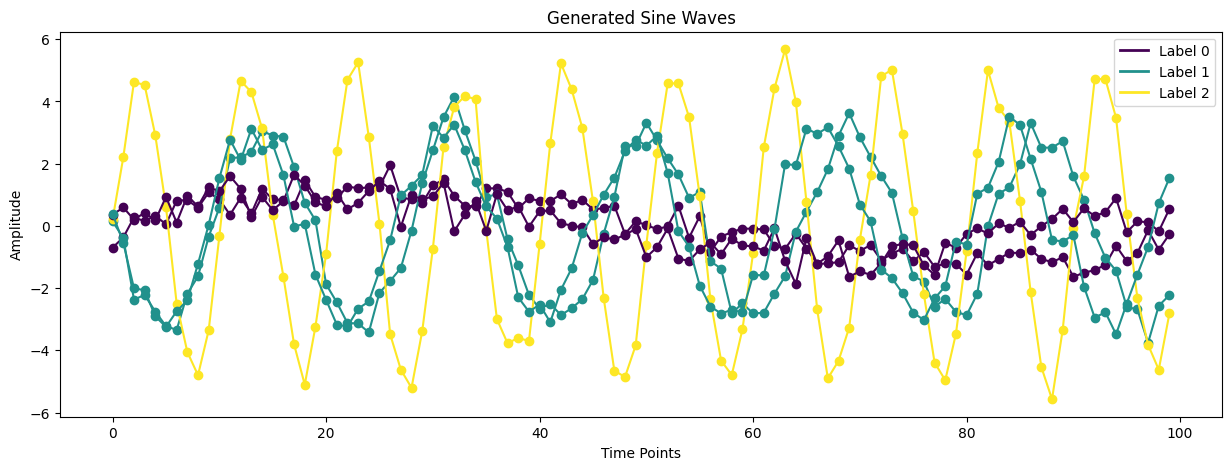

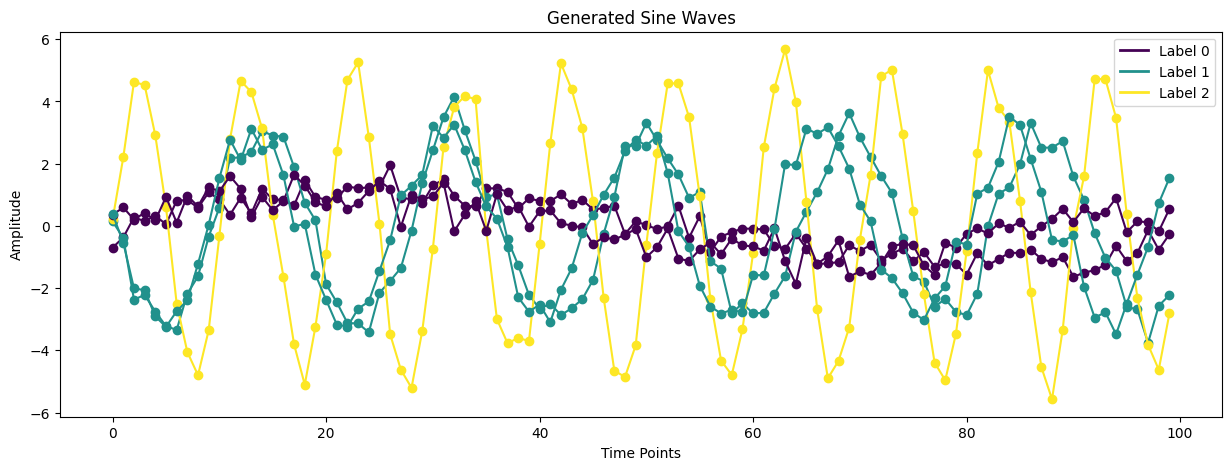

In [20]:
# compare labels with predicted_labels
plot.plot_df(data, labels)
plot.plot_df(data, predicted_labels)

In [21]:
# plot.plot_cluster_variables(samples, [1, 6, 26, 41], ax, states_from_chain=2)


# Data 2

In [22]:
# Adjust the synthetic time series to match the specific behaviors described with peaks closer to the beginning for series 1 and 3 with less linear and more noise-induced peaks
np.random.seed(42)
n_points = 500
time = np.linspace(0, 10, n_points)

# Generate base time series
base_series = np.zeros(n_points)

# Apply specific patterns with smoother transitions for series 1 and 3
peak_position = n_points // 4
series1_peak = np.cumsum(np.random.normal(0, 0.2, peak_position))
series1_taper = np.cumsum(np.random.normal(0, 0.05, n_points - peak_position))
series1 = +3 + np.concatenate((series1_peak, -series1_taper + series1_peak[-1]))
series1 += np.random.normal(0, 0.1, n_points)

series3_peak = np.cumsum(np.random.normal(0, 0.2, peak_position))
series3_taper = np.cumsum(np.random.normal(0, 0.05, n_points - peak_position))
series3 = -5 + np.concatenate((series3_peak, -series3_taper + series3_peak[-1]))
series3 += np.random.normal(0, 0.1, n_points)

series2 = base_series + np.cumsum(np.random.normal(0, 0.05, n_points))
#series2[300:] += np.linspace(0, 1, n_points - 300)

series4 = base_series + np.cumsum(np.random.normal(0, 0.1, n_points)) + 2
series4[100:150] -= 2
series4[300:350] -= 2
series4 += (series4[0] - series4[-1])  # Normalize end values to be similar to start values

series5 = 2 + np.cumsum(np.random.normal(0, 0.1, n_points))
series5[100:150] -= np.linspace(0, 2, 50)
series5[300:350] -= np.linspace(0, 2, 50)
series5 -= series5[-1] - 2  # Normalize end values to 2

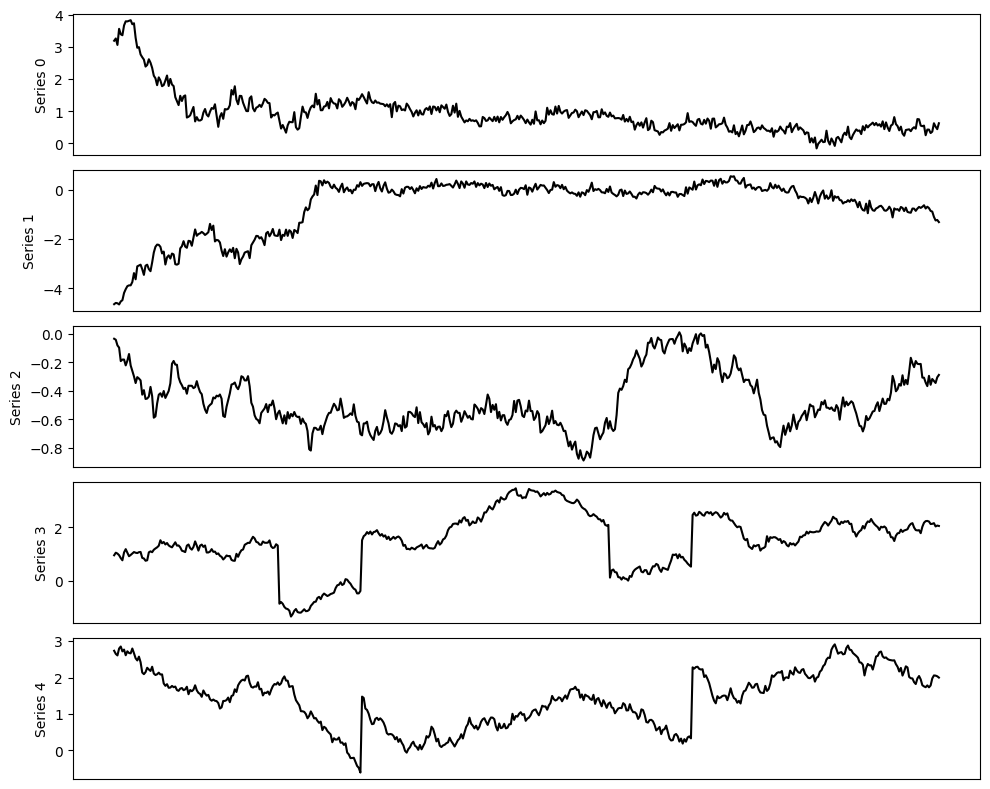

In [23]:
import pandas as pd

# Create a DataFrame to store the time series data
data_dict = {
    'Series 0': series1,
    'Series 1': series3,
    'Series 2': series2,
    'Series 3': series4,
    'Series 4': series5
}

df_time_series = pd.DataFrame(data_dict)

# Plot the 5 time series
plt.figure(figsize=(10, 8))

plt.subplot(5, 1, 1)
plt.plot(df_time_series.index, df_time_series['Series 0'], color='black')
plt.ylabel('Series 0')
plt.xticks([])

plt.subplot(5, 1, 2)
plt.plot(df_time_series.index, df_time_series['Series 1'], color='black')
plt.ylabel('Series 1')
plt.xticks([])

plt.subplot(5, 1, 3)
plt.plot(df_time_series.index, df_time_series['Series 2'], color='black')
plt.ylabel('Series 2')
plt.xticks([])

plt.subplot(5, 1, 4)
plt.plot(df_time_series.index, df_time_series['Series 3'], color='black')
plt.ylabel('Series 3')
plt.xticks([])

plt.subplot(5, 1, 5)
plt.plot(df_time_series.index, df_time_series['Series 4'], color='black')
plt.ylabel('Series 4')
plt.xticks([])

plt.tight_layout()
plt.show()

#df_time_series


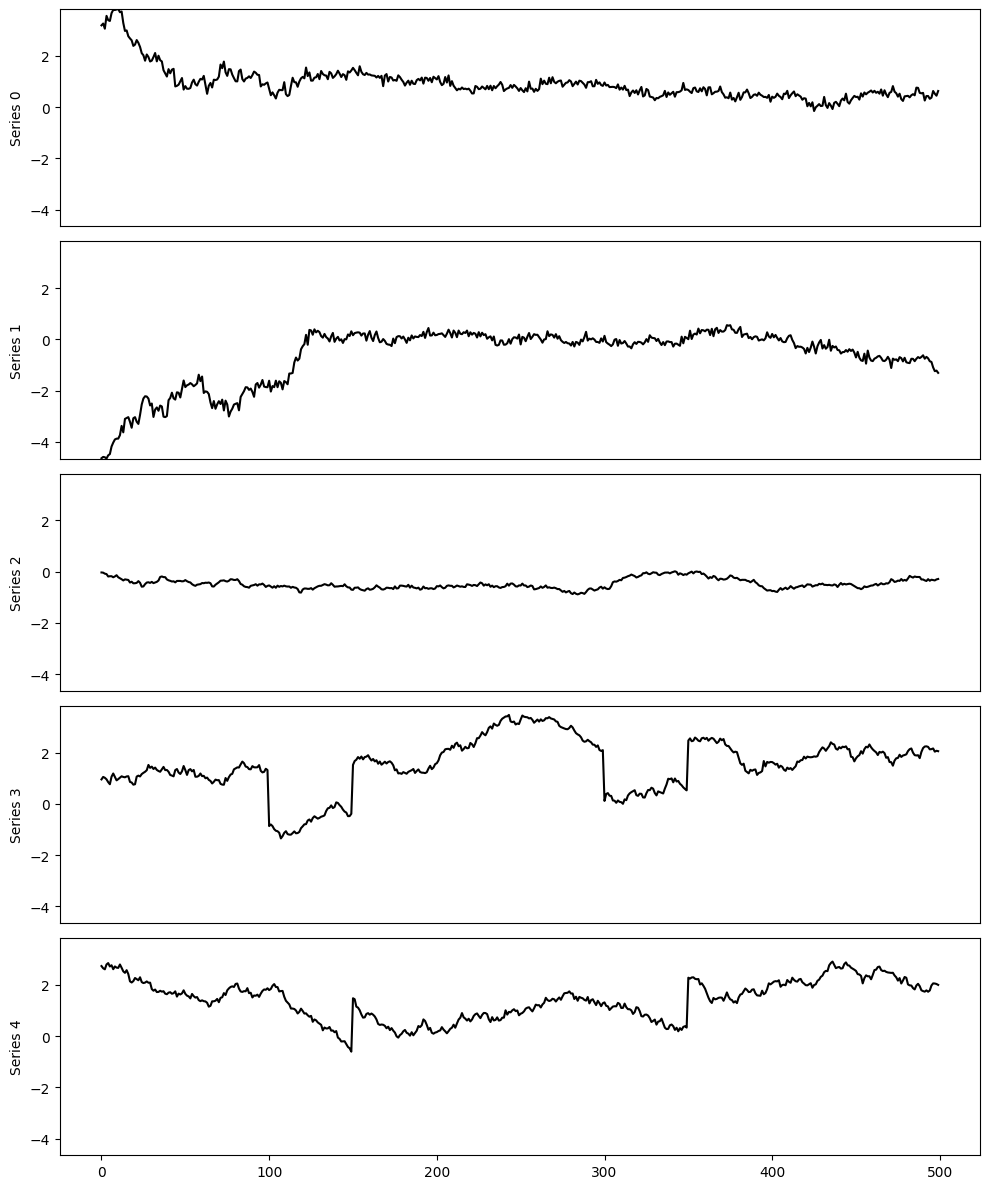

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming series1, series2, series3, series4, series5 are defined

# Create a DataFrame to store the time series data
data_dict = {
    'Series 0': series1,
    'Series 1': series3,
    'Series 2': series2,
    'Series 3': series4,
    'Series 4': series5
}

df_time_series = pd.DataFrame(data_dict)

# Determine the common y-axis limits
y_min = df_time_series.min().min()
y_max = df_time_series.max().max()

# Plot the 5 time series with the same y-axis scale
fig, axs = plt.subplots(5, 1, figsize=(10, 12))

for i, series in enumerate(df_time_series.columns):
    axs[i].plot(df_time_series.index, df_time_series[series], color='black')
    axs[i].set_ylabel(series)
    axs[i].set_ylim([y_min, y_max])
    if i < 4:
        axs[i].set_xticks([])

plt.tight_layout()
plt.show()


In [25]:
model = helpers.run_model(df_time_series)

MCMC inference time: 4 minutes and 12 seconds
Hyperparameter optimization time: 1 minutes and 30 seconds


In [26]:
importlib.reload(helpers)

<module 'experiments.helper_functions' from '/hdsi-collab-persistent/cephfs/Setup/experiments/helper_functions.py'>

In [27]:
dep_matrices = helpers.post_dep(model, 25)

Sampling Time: 1 minutes and 10 seconds


In [28]:
predicted_clusters = helpers.clustering(dep_matrices, threshold = 0.85)
predicted_clusters

[{0, 1, 2, 3, 4}]

In [29]:
df_time_series.head()

,Series 0,Series 1,Series 2,Series 3,Series 4
0,3.191961,-4.642293,-0.033759,0.954883,2.735536
1,3.262632,-4.590321,-0.040985,1.051702,2.649498
2,3.061371,-4.605096,-0.080606,1.018571,2.608137
3,3.562131,-4.653001,-0.096004,0.957347,2.796906
4,3.393939,-4.530037,-0.190685,0.848832,2.852561


### Trial Plot

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states == state]
        for x in xs:
            ax.fill_between([x - 1, x], [y_mid - y_height] * 2, [y_mid + y_height] * 2,
                            alpha=0.3, color=color)

def plot_temporal_regimes(variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:, variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    ax.set_ylim([min(y_observed) - 2, max(y_observed) + 2])
    # Optionally plot latent temporal state at each timepoint,
    # according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)



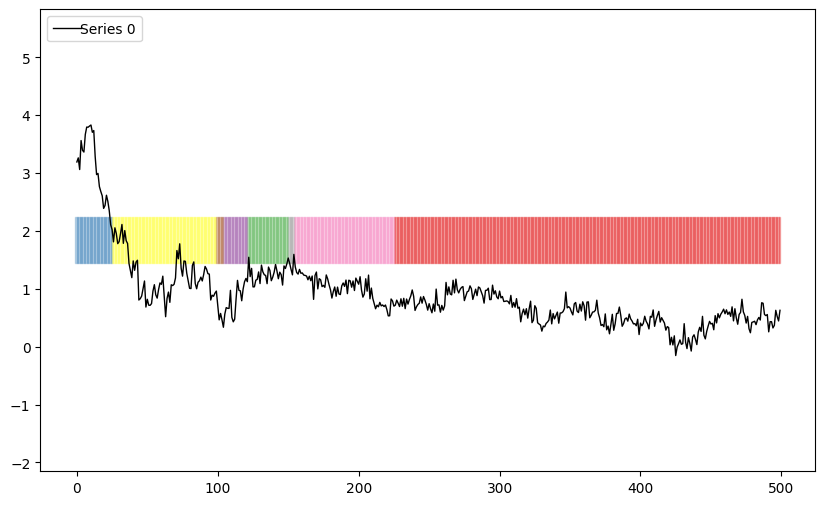

In [31]:
# Example usage
fig, ax = plt.subplots(figsize=(10, 6))
plot_temporal_regimes(variable='Series 0', ax=ax, states_from_chain=0)
plt.show()

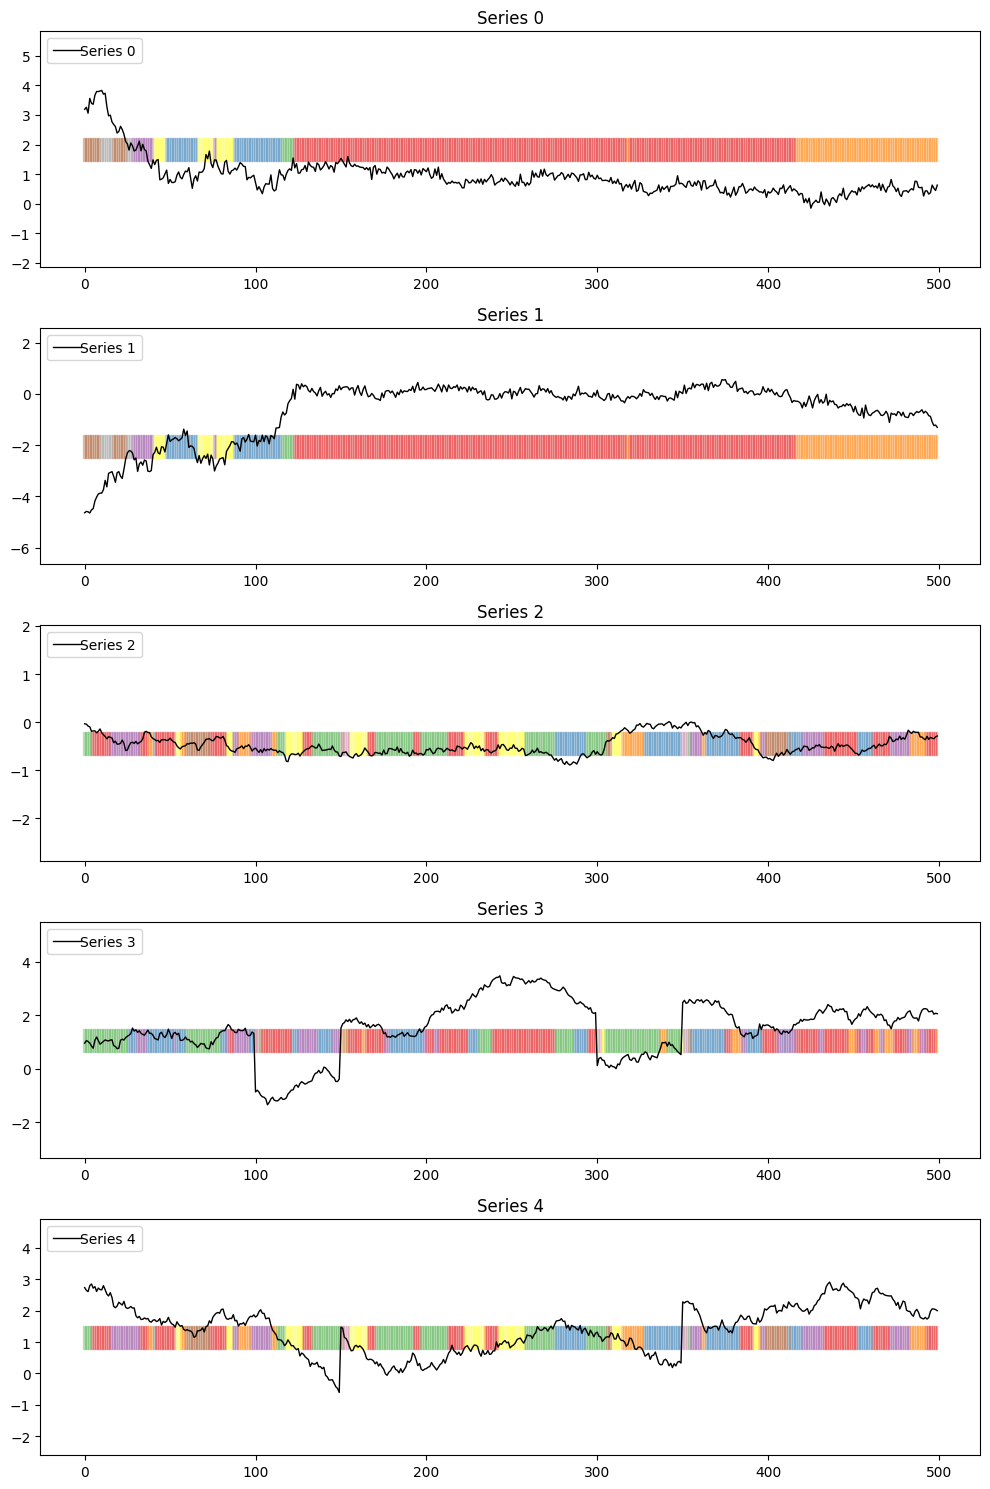

In [32]:
fig, axs = plt.subplots(5, 1, figsize=(10, 15))

for i, series in enumerate(df_time_series.columns):
    plot_temporal_regimes(variable = series, ax = axs[i], states_from_chain = 5)
    axs[i].set_title(series)

plt.tight_layout()
plt.show()

### Data 3

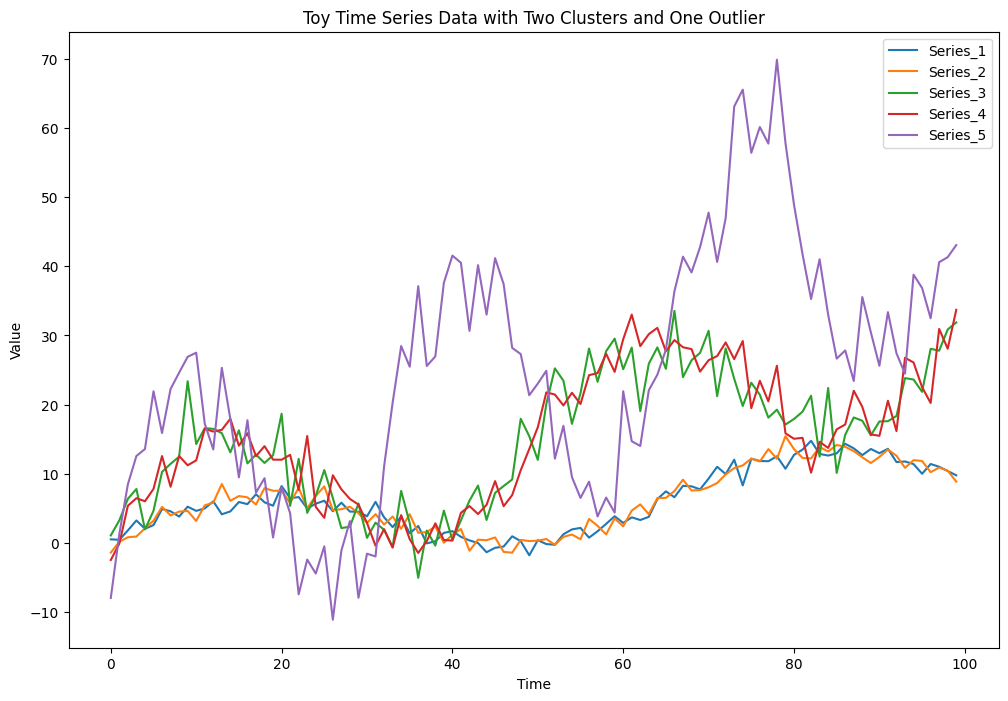

,Series_1,Series_2,Series_3,Series_4,Series_5
0,0.496714,-1.415371,1.073362,-2.486985,-7.972138
1,0.438026,0.155645,3.251308,-0.111588,1.293200
2,1.795965,0.805562,6.366694,5.359421,8.469569
3,3.234723,0.909416,7.787122,6.456826,12.562871
4,2.028199,2.101067,1.941080,6.011384,13.571455


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
n_series = 5  # Number of time series
n_observations = 100  # Number of observations per time series

# Generate toy data with two distinct clusters and one outlier
time_series_data_v4 = {}
for i in range(n_series):
    if i == n_series - 1:
        # Significantly different signal for the last series (outlier)
        trend = np.linspace(0, 50, n_observations)
        seasonal = 20 * np.sin(np.linspace(0, 6 * np.pi, n_observations))
        noise = np.random.normal(0, 5, n_observations)
    elif i in [n_series - 2, n_series - 3]:
        # Distinct signal for another cluster
        trend = np.linspace(0, 30, n_observations)
        seasonal = 10 * np.sin(np.linspace(0, 4 * np.pi, n_observations))
        noise = np.random.normal(0, 3, n_observations)
    else:
        # Normal signals
        trend = np.linspace(0, 10, n_observations)
        seasonal = 5 * np.sin(np.linspace(0, 3 * np.pi, n_observations))
        noise = np.random.normal(0, 1, n_observations)
    time_series_data_v4[f"Series_{i+1}"] = trend + seasonal + noise

# Convert to DataFrame with time series as columns
df_v4 = pd.DataFrame(time_series_data_v4)

# Display the DataFrame
#import ace_tools as tools; tools.display_dataframe_to_user(name="Adjusted Toy Time Series Data with Two Clusters and One Outlier", dataframe=df_v4)

# Plot the generated time series data
plt.figure(figsize=(12, 8))
for i in range(n_series):
    plt.plot(df_v4[f"Series_{i+1}"], label=f"Series_{i+1}")
plt.title('Toy Time Series Data with Two Clusters and One Outlier')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

df_v4.head()


In [34]:
model = helpers.run_model(df_v4)

MCMC inference time: 0 minutes and 48 seconds
Hyperparameter optimization time: 0 minutes and 38 seconds


In [35]:
dep_matrices = helpers.post_dep(model, 25)

Sampling Time: 0 minutes and 24 seconds


In [36]:
predicted_clusters = helpers.clustering(dep_matrices, threshold = 0.9
                                       )
predicted_clusters

[{0, 1}, {2, 3}, {4}]

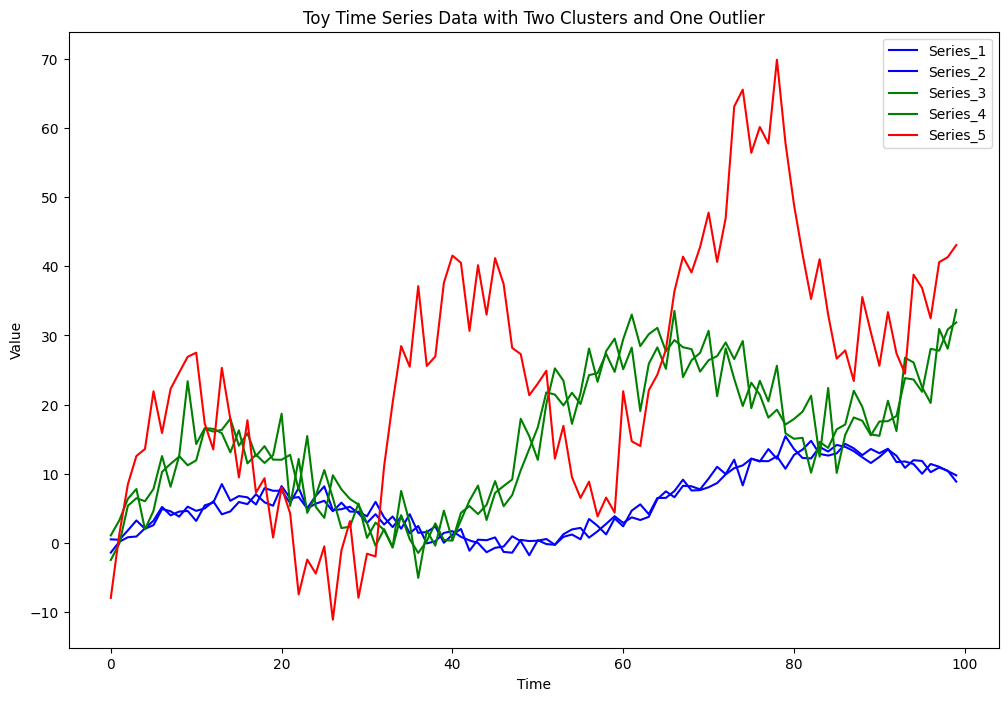

In [37]:
# Create a color map based on the predicted clusters
cluster_colors = {
    0: 'blue',    # Cluster 1
    1: 'blue',    # Cluster 1
    2: 'green',   # Cluster 2
    3: 'green',   # Cluster 2
    4: 'red'      # Outlier
}

# Plot the generated time series data with clusters
plt.figure(figsize=(12, 8))
for i in range(n_series):
    plt.plot(df_v4[f'Series_{i+1}'], label=f'Series_{i+1}', color=cluster_colors[i])
plt.title('Toy Time Series Data with Two Clusters and One Outlier')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


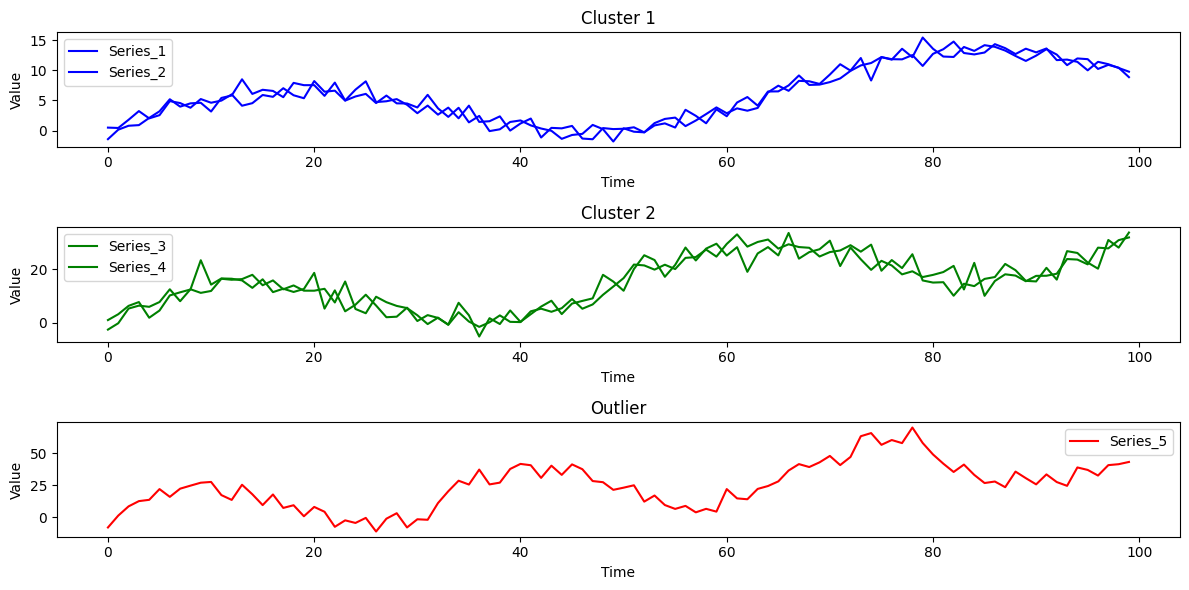

In [38]:
# Plot the generated time series data with separate plots for each cluster
plt.figure(figsize=(12, 6))

# Plot for Cluster 1
plt.subplot(3, 1, 1)
for i in [0, 1]:
    plt.plot(df_v4[f'Series_{i+1}'], label=f'Series_{i+1}', color='blue')
plt.title('Cluster 1')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Plot for Cluster 2
plt.subplot(3, 1, 2)
for i in [2, 3]:
    plt.plot(df_v4[f'Series_{i+1}'], label=f'Series_{i+1}', color='green')
plt.title('Cluster 2')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Plot for Outlier
plt.subplot(3, 1, 3)
plt.plot(df_v4['Series_5'], label='Series_5', color='red')
plt.title('Outlier')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


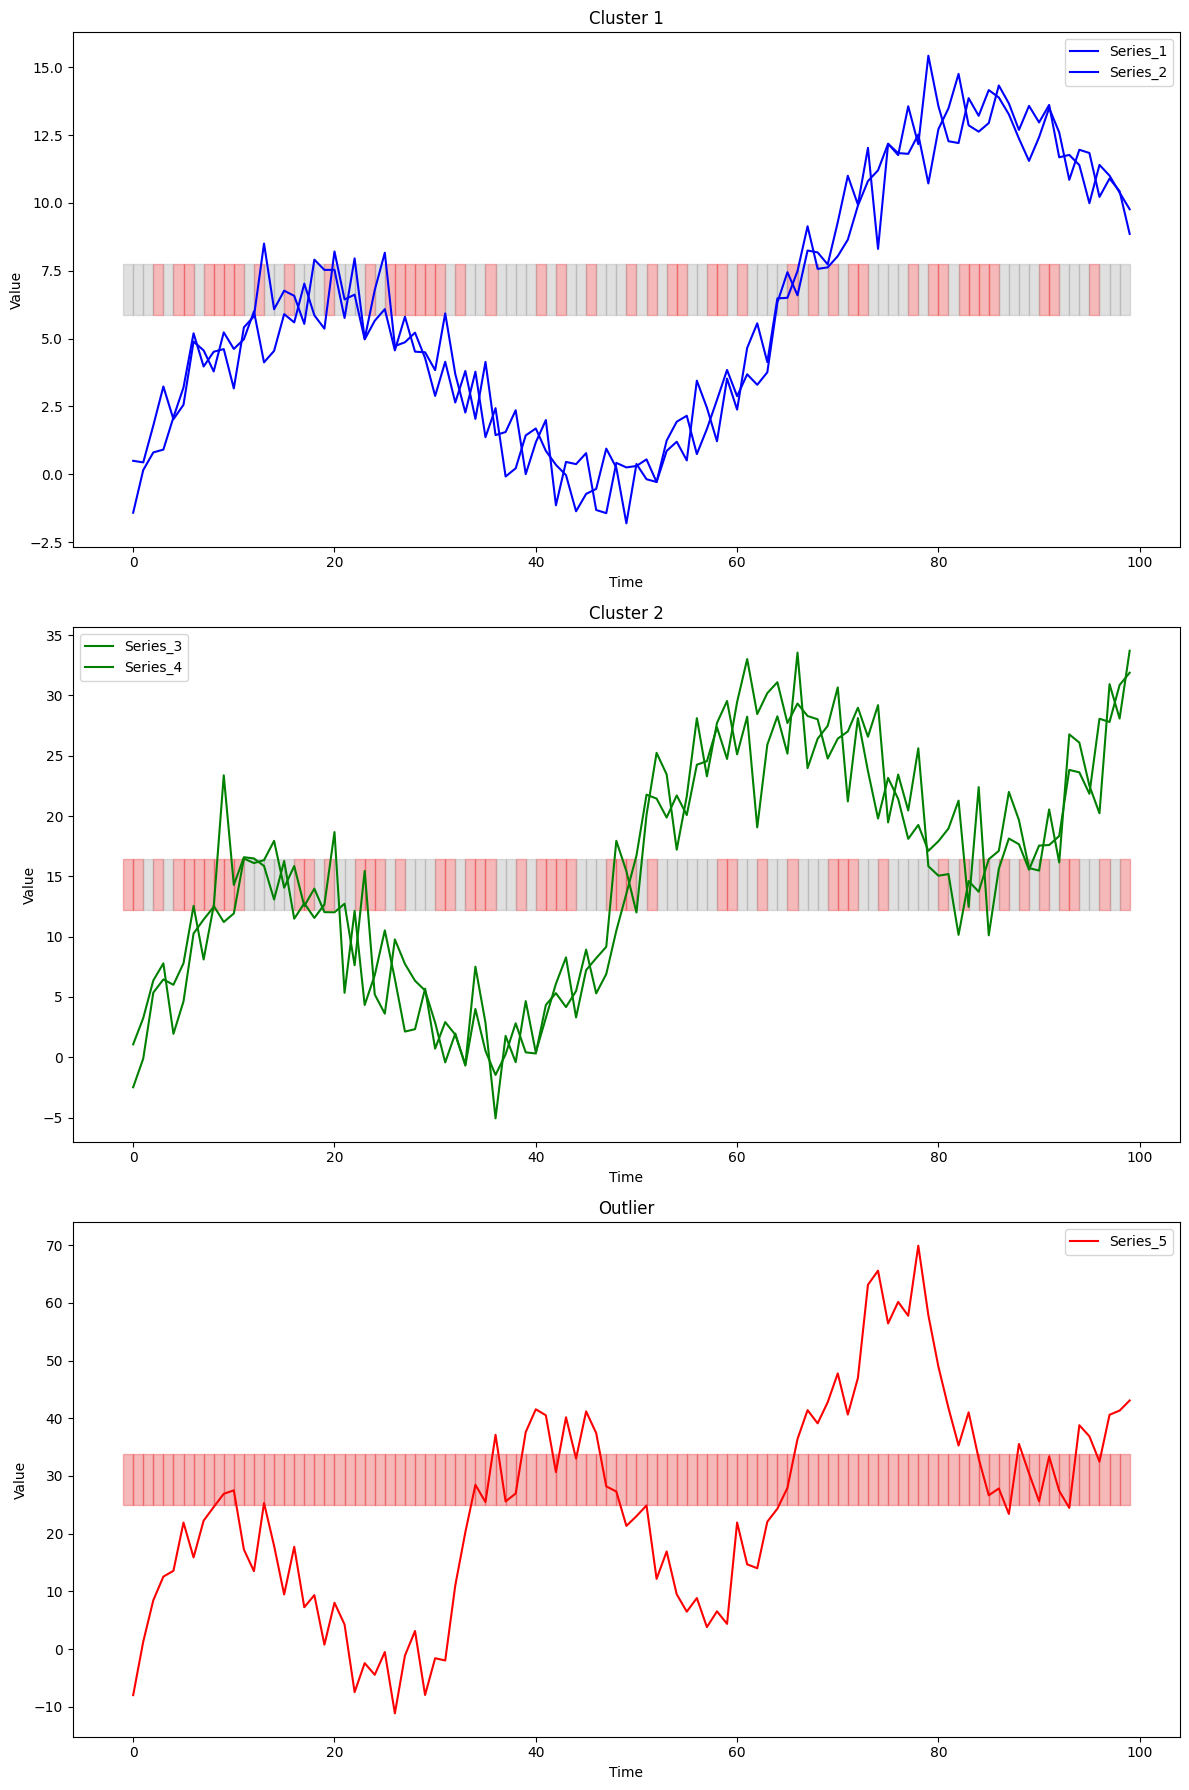

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Define the function to plot latent state sequences
def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states == state]
        for x in xs:
            ax.fill_between([x - 1, x], [y_mid - y_height] * 2, [y_mid + y_height] * 2,
                            alpha=0.3, color=color)

# Generate latent state sequences for each time series
latent_states = {
    0: np.random.choice([0, 1], size=n_observations),
    1: np.random.choice([0, 1], size=n_observations),
    2: np.random.choice([2, 3], size=n_observations),
    3: np.random.choice([2, 3], size=n_observations),
    4: np.random.choice([4], size=n_observations)  # Single state for the outlier
}

# Plot the time series with latent state sequences
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot for Cluster 1
ax = axes[0]
for i in [0, 1]:
    ax.plot(df_v4.index, df_v4[f'Series_{i+1}'], label=f'Series_{i+1}', color='blue')
plot_latent_state_sequence(df_v4.index, df_v4['Series_1'], latent_states[0], ax)
ax.set_title('Cluster 1')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Plot for Cluster 2
ax = axes[1]
for i in [2, 3]:
    ax.plot(df_v4.index, df_v4[f'Series_{i+1}'], label=f'Series_{i+1}', color='green')
plot_latent_state_sequence(df_v4.index, df_v4['Series_3'], latent_states[2], ax)
ax.set_title('Cluster 2')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Plot for Outlier
ax = axes[2]
ax.plot(df_v4.index, df_v4['Series_5'], label='Series_5', color='red')
plot_latent_state_sequence(df_v4.index, df_v4['Series_5'], latent_states[4], ax)
ax.set_title('Outlier')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

plt.tight_layout()
plt.show()


In [40]:
latent_states[0]

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1])

In [41]:
model.chains

8

In [42]:
model.get_temporal_regimes('Series_1')

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3],
       [7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 6, 6,
        6, 6, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1,

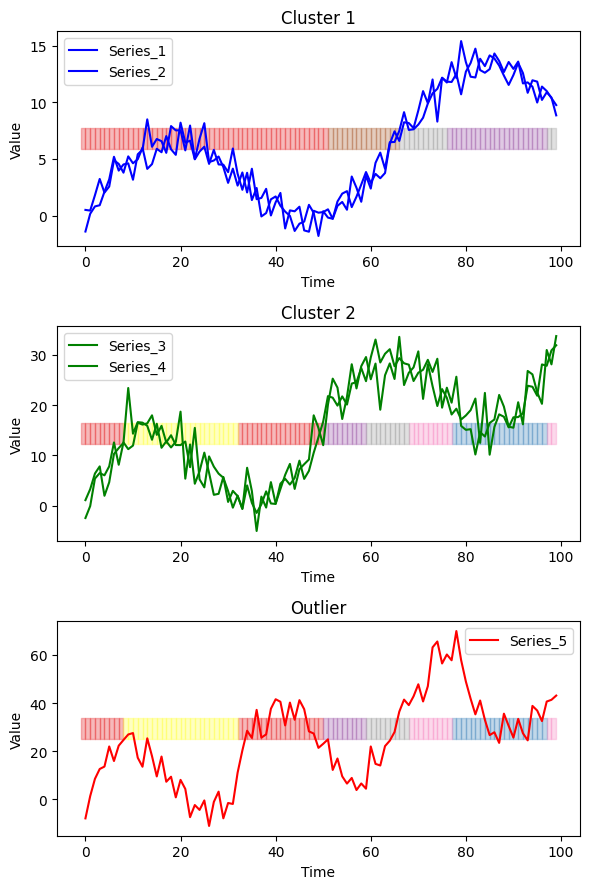

In [45]:
num = 7
latent_states = {
    0: model.get_temporal_regimes('Series_1')[2],
    1: model.get_temporal_regimes('Series_2')[2],
    2: model.get_temporal_regimes('Series_3')[4],
    3: model.get_temporal_regimes('Series_4')[num],
    4: model.get_temporal_regimes('Series_5')[4]
}

# Plot the time series with latent state sequences
fig, axes = plt.subplots(3, 1, figsize=(6, 9))

# Plot for Cluster 1
ax = axes[0]
for i in [0, 1]:
    ax.plot(df_v4.index, df_v4[f'Series_{i+1}'], label=f'Series_{i+1}', color='blue')
plot_latent_state_sequence(df_v4.index, df_v4['Series_1'], latent_states[0], ax)
ax.set_title('Cluster 1')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Plot for Cluster 2
ax = axes[1]
for i in [2, 3]:
    ax.plot(df_v4.index, df_v4[f'Series_{i+1}'], label=f'Series_{i+1}', color='green')
plot_latent_state_sequence(df_v4.index, df_v4['Series_3'], latent_states[2], ax)
ax.set_title('Cluster 2')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Plot for Outlier
ax = axes[2]
ax.plot(df_v4.index, df_v4['Series_5'], label='Series_5', color='red')
plot_latent_state_sequence(df_v4.index, df_v4['Series_5'], latent_states[4], ax)
ax.set_title('Outlier')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

plt.tight_layout()
plt.show()